# Data prepare 

This segment prepares dataset containig normalized sound recordings extended with temperature and humidity values. For now we support only one hive for data preparation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
# 1300001 - hive
# 1300002 - not hive?
# 1400001 - hive szymanski
# 1400002 - hive szymanski
#hives_ids = [1300001, 1300002, 1400001, 1400002]

hives_ids = [1300001]
DATA_INIT = True

In [3]:
if DATA_INIT:
    dfh_hives = [pd.read_csv(f"measurements/{hive_id}/humidity.csv") for hive_id in hives_ids]
    dft_hives = [pd.read_csv(f"measurements/{hive_id}/temperature.csv") for hive_id in hives_ids]
    dfh_hivesWithoutDuplicates = [dfh_hive.drop_duplicates(subset=['timestamp'], keep=False) for dfh_hive in dfh_hives]
    dft_hivesWithoutDuplicates = [dft_hive.drop_duplicates(subset=['timestamp'], keep=False) for dft_hive in dft_hives]

    for idx, hive_id in enumerate(hives_ids):
        print(f"Hive no. {hives_ids[idx]} | humidity temperature dataset size : {dfh_hivesWithoutDuplicates[idx].shape} {dft_hivesWithoutDuplicates[idx].shape}")

    df_hive = [pd.merge(
        dfh_hivesWithoutDuplicates[idx], dft_hivesWithoutDuplicates[idx], on='timestamp', suffixes=(f"_humidity_{hive_id}",f"_temperature_{hive_id}"))
               for idx, hive_id in enumerate(hives_ids)]

    
    total = 0
    for atmosphere_data in df_hive:
        atmosphere_data['timestamp'] = pd.to_datetime(atmosphere_data['timestamp'], format='%Y-%m-%dT%H-%M-%S').sort_values()
        atmosphere_data.set_index('timestamp', inplace=True)
        print(f"Atmospheric data after merge: {atmosphere_data.shape}")
        total += atmosphere_data.shape[0]
    
    print(f"Total atmoshpere dataset size: {total}")

Hive no. 1300001 | humidity temperature dataset size : (6776, 2) (6786, 2)
Atmospheric data after merge: (6696, 2)
Total atmoshpere dataset size: 6696


In [4]:
import glob 

if DATA_INIT:
    hive_sounds = []
    hive_timestamps = []
    for idx, hive_id in enumerate(hives_ids):
        print(f"Data preparation for hive: {hive_id}")

        sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        sound_hive_list = []
        for file in tqdm(sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples['samples'].values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                #np_samples = scaler.fit_transform(np_samples.reshape(-1, 1))
                hive_sounds.append([pd_timestamp, np_samples])
    sound_pd = pd.DataFrame(hive_sounds, columns=['timestamp', 'samples'])
    sound_pd = sound_pd.set_index('timestamp')
    
    # Merge with atmosphere data
    for index, row in sound_pd.iterrows():
        atmosphere_nearest = atmosphere_data.iloc[atmosphere_data.index.get_loc(index, method='nearest')]
        sound_pd.loc[index, 'humidity'] = atmosphere_nearest[f"value_humidity_{hives_ids[0]}"]
        sound_pd.loc[index, 'temperature'] = atmosphere_nearest[f"value_temperature_{hives_ids[0]}"]
    
    np.save(f"{hives_ids[0]}-data.npy", sound_pd)
    df_data = sound_pd
else:
    sound_pd = np.load(f"{hives_ids[0]}-data.npy", allow_pickle=True)
    print(f"Loaded dataset with size {len(hive_sounds)}.")

Data preparation for hive: 1300001


100%|██████████| 1664/1664 [00:03<00:00, 447.37it/s]


# MFCC

This block assumes that we have data in <code>df_data</code> variable.

In [5]:
import librosa
import librosa.display

data_mfcc_labeled = []
night_timestamps = df_data.between_time("23:00", "3:30").index.values.tolist()
night_timestamps = pd.to_datetime(night_timestamps)

for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
    full_mfccs = librosa.feature.mfcc(y=row['samples'], sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
    data_mfcc_labeled.append([np.mean(full_mfccs,axis=1), row['temperature'], row['humidity'],
                              int(index in night_timestamps)])

100%|██████████| 1652/1652 [00:04<00:00, 375.34it/s]


# Basic classification PCA

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

standarized_mfcc_avg = StandardScaler().fit_transform([data[0] for data in data_mfcc_labeled])
standarized_temp = StandardScaler().fit_transform([[data[1]] for data in data_mfcc_labeled])
standarized_hum = StandardScaler().fit_transform([[data[2]] for data in data_mfcc_labeled])

zipped_data = list(zip(standarized_mfcc_avg, standarized_temp, standarized_hum))
merged_data = [np.concatenate(list_to_con) for list_to_con in zipped_data]
#standarized_merged_data = StandardScaler().fit_transform(merged_data)

pca = PCA(n_components=2)
pc_data = pca.fit_transform(merged_data)

# Basic classification t-sne

In [26]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(merged_data)

# Visualize

100%|██████████| 1652/1652 [00:03<00:00, 440.91it/s]


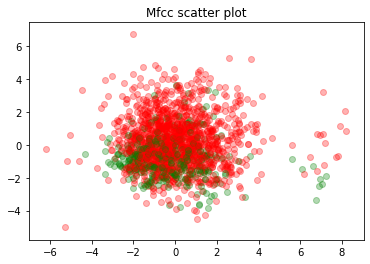

In [29]:
pc_data_labeled = list(zip(pc_data, [mfcc_data[3] for mfcc_data in data_mfcc_labeled]))

colors = ['red', 'green', 'blue', 'yellow']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, label in tqdm(pc_data_labeled):
    x, y = data
    ax.scatter(x, y, c=colors[label], alpha=0.3)

plt.title("Mfcc scatter plot")
plt.savefig('PCA_pelny_set_mfcc_bez_ost_standaryzacji.png')
plt.show()

# AUTOENCODER - BASIC

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
learning_rate = 1e-4

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3000, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256))
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 3000), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import torch.utils.data as utils

sound_dataset = utils.TensorDataset(torch.Tensor([x[0] for x in training_data_sound]),
                                   torch.Tensor([x[1] for x in training_data_sound])) # create your datset
                                    
print("Length of complete sound dataset is", len(sound_dataset))
sound_trainset = torch.utils.data.DataLoader(sound_dataset, batch_size=20, shuffle=True)

In [ ]:
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

for epoch in range(num_epochs):
    for data in tqdm(sound_trainset):
        X, y = data
        model.zero_grad()
        output = model(X)
        loss = criterion(output, X)
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f"epoch [{epoch}/{num_epochs}], loss:{loss.item()}")

In [ ]:
torch.save(model.state_dict(), 'autoencoder-basic-model.pth')

### Evaluation

In [ ]:
model.load_state_dict(torch.load('autoencoder-basic-model.pth'))

In [ ]:
with torch.no_grad():
    for data in tqdm(sound_trainset):
        X, y = data
        output = model(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

# AUTOENCODER CNN

In [31]:
a = [1,2,3,4,5,6,7,7,8,98,90,0]
print(a[:-3])

[1, 2, 3, 4, 5, 6, 7, 7, 8]


# PyTorch

# ---------------


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
train = datasets.MNIST("", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [ ]:
print(train)

In [ ]:
trainset = torch.utils.data.DataLoader(train, batch_size=20, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=20, shuffle=True)

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def weight_reset(m):
        if isinstance(m, nn.Linear):
            m.reset_parameters()
        
        
net = Net()


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=1e-3)
EPOCHS = 6

net.weight_reset()

for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data
        net.zero_grad()
        output = net(X.view(-1, 784))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    print("Current loss is: ", loss.item())
    if loss < 1e-5:
        print("Loss threshold obtained!")
        break
        

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
            
print("Accuracy on test data: ", round(correct/total, 3))

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
            
print("Accuracy on train data: ", round(correct/total, 3))